# **ML Modeling and Evaluation - Classification**

## Objectives

* Fit a feature engineering pipeline
* Fit a classification model to predict the health risk level of patients
* Evaluate the classification model performance
  
## Inputs

* Cleaned Maternal Health Risks dataset: outputs/cleaned/maternal-health-risk-dataset-clean.csv
* Instructions on feature engineering steps to take (see previous notebook)

## Outputs

* Train set (features and target)
* Test set (features and target)
* Feature engineering pipeline
* Modeling pipeline
* Feature importance plot

---

# Import Packages for Data Collection

In [43]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# feature engineering
from feature_engine import transformation as vt
from feature_engine.selection import SmartCorrelatedSelection

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# scaling
from sklearn.preprocessing import StandardScaler

# feauture selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# grid search
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, recall_score

%matplotlib inline

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/ML-maternal-health-risk/jupyter_notebooks'

Make the parent of the current directory the new current directory, and confirm new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* os.getcwd() get the current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"New current directory set to {current_dir}.")

New current directory set to /workspaces/ML-maternal-health-risk.


# Step 1: Load Data

Recall that we can directly load the cleaned dataset, since the only data cleaning we had to do was to remove 3 (suspectedly) erronous datapoints. There were no steps that could be performed in a data cleaning pipeline.

In [34]:
df = pd.read_csv('outputs/datasets/cleaned/maternal-health-risk-dataset-clean.csv')
print(df.shape)
df.head()

(1011, 7)


,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,36.7,86,2
1,35,140,90,13.0,36.7,70,2
2,29,90,70,8.0,37.8,80,2
3,30,140,85,7.0,36.7,70,2
4,35,120,60,6.1,36.7,76,0


---

# Step 2: ML pipeline with all Data

## ML Pipeline for Feature Engineering

In this section we will implement the ML pipeline for feature engineering. Recall that we do not need a DataCleaning Pipeline in this project due to an already clean dataset.

We implement a pipeline including the following steps:

* Numerical Transformations: Box-Cox transformation for `["Age", "SystolicBP", "BloodSugar"]`
* SmartCorrelatedSelection (which will drop `["DiastolicBP"]`)

Define the Featureengineering pipeline and call it

In [7]:
def PipelineFeatureEngineering():
    """
    Defines a pipeline including the feature engineering steps from above
    Box-Cox transformation
    SmartCorrelatedSelection
    """
    pipeline_base = Pipeline([
        ("BoxCoxTransformation", vt.BoxCoxTransformer(variables=[
                                                    "Age",
                                                    "SystolicBP",
                                                    "BloodSugar"
                                                    ])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
                                        variables=None,
                                        method="spearman",
                                        threshold=0.6,
                                        selection_method="variance"
                                        )),
    ])

    return pipeline_base


PipelineFeatureEngineering()

Pipeline(steps=[('BoxCoxTransformation',
                 BoxCoxTransformer(variables=['Age', 'SystolicBP',
                                              'BloodSugar'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimization

Define a pipeline that handles the ML Classifier modelling. It also includes feature scaling and feature selection which both need to happen after the feature engineering step.
We choose the StandardScaler to scale our features and the SelectFromModel to select the most important features to train the model.

In [10]:
def PipelineClassifier(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Next, we will conduct a hyperparameter optimization search to get the classification model as well as the hyperparameters that fit our dataset the best.

We start with a custom class for an efficient hyperparameter optimisation as well as algorithm search.

In [13]:
# The code for this class was taken from the Code Institute churnometer walkthrough project and adapted for this project


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClassifier(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


### Split into Train and Test Set

Before getting into the hyperparameter optimisation we need to split our dataset into train and test set

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['RiskLevel'], axis=1),
    df['RiskLevel'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(808, 6) (808,) (203, 6) (203,)


### Fit Feature Engineering Pipeline to Train Set

In [36]:

# Create feature engineering pipeline
pipeline_feat_eng = PipelineFeatureEngineering()

# fit on the train set and transform train set
X_train = pipeline_feat_eng.fit_transform(X_train)
# transform the test set
X_test = pipeline_feat_eng.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(808, 5) (808,) (203, 5) (203,)


### **Handle Target Imbalance**

As mentioned in the data collection notebook the RiskLevel target column is moderately imbalanced. To improve model performance we perform SMOTE (Synthetic Minority Oversamplin Technique) to balance the train set by creating synthetic data. Importantly, we do this after fitting the feature engineering pipeline.

Plot the target distribution from the train set:

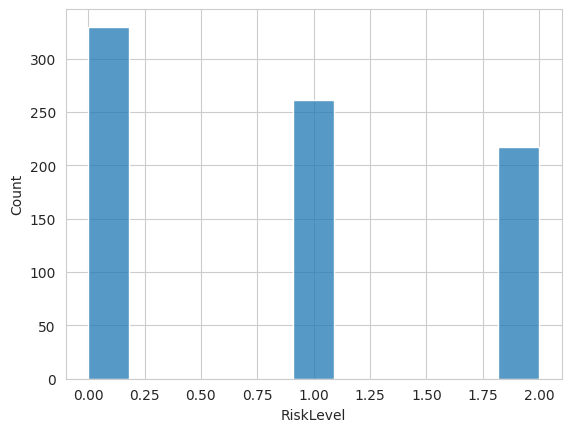

In [29]:
sns.set_style("whitegrid")
sns.histplot(data=y_train)
plt.show()

In [38]:
y_train.value_counts()

RiskLevel
0    330
1    261
2    217
Name: count, dtype: int64

**Resample the dataset with SMOTE**

The sample is slightly imbalanced with RiskLevel counts:
* low-risk (0): 330
* mid-risk (1): 261
* high-risk (2): 217

We decide to take a moderate oversampling approach of resampling both mid-risk and high-risk to 300. This is because, even though a totally balanced dataset might be advantageous for the classifier models, there is a risk of overfitting the models. Since our dataset is relatively small, generating too much synthetic high-risk data might overfit our model towards high-risk.

Fit and resample the test set:

In [40]:
# Create SMOTE object

oversample = SMOTE(
                sampling_strategy={
                1: 300,
                2: 300
                }, 
                random_state=0
                )

# fit oversample to train set and resample the train set
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(930, 5) (930,) (203, 5) (203,)


Check the target distibution for the train set again after resampling. It is now more balanced but purposefully not completely balanced.

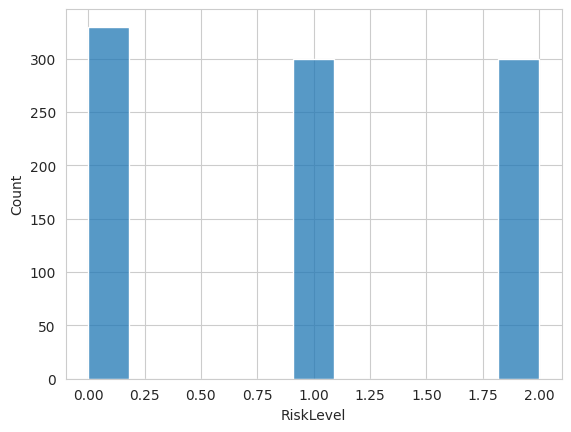

In [41]:
sns.set_style("whitegrid")
sns.histplot(data=y_train)
plt.show()

### Grid Search for hyperparameter optimisation

We use Grid Search CV to conduct a hypermarameter optimisation search. The first step is to focus on finding the most suitable algorithm before optimizing its hyperparameters.

So let us first search through many different classification algorithms using only their standard hyperparameters for efficiency. Next, we will choose the best algorithm and conduct an extensive hyperparameter optimisation search on this specific algorithm (or several good ones).

In [55]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "AdaBoostClassifier": {},
    "ExtraTreesClassifier": {},
    "GradientBoostingClassifier": {},
    "XGBClassifier": {},
}

In [74]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(
                X_train,
                y_train,
                scoring = make_scorer(recall_score, labels=[2], average=None),
                # scoring = make_scorer(recall_score, average="weighted"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [75]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,AdaBoostClassifier,0.8,0.88,0.933333,0.04397
2,RandomForestClassifier,0.766667,0.86,0.933333,0.056372
6,XGBClassifier,0.766667,0.836667,0.883333,0.038586
5,GradientBoostingClassifier,0.766667,0.823333,0.866667,0.035901
4,ExtraTreesClassifier,0.766667,0.816667,0.866667,0.042164
1,DecisionTreeClassifier,0.566667,0.753333,0.85,0.100775
0,LogisticRegression,0.6,0.753333,0.883333,0.097411


In [76]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(
                X_train,
                y_train,
                # scoring = make_scorer(recall_score, labels=[2], average=None),
                scoring = make_scorer(recall_score, average="weighted"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [77]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestClassifier,0.666667,0.763441,0.844086,0.063523
6,XGBClassifier,0.672043,0.726882,0.77957,0.034071
4,ExtraTreesClassifier,0.672043,0.71828,0.758065,0.028163
5,GradientBoostingClassifier,0.672043,0.716129,0.741935,0.024614
1,DecisionTreeClassifier,0.607527,0.683871,0.747312,0.046919
3,AdaBoostClassifier,0.629032,0.658065,0.698925,0.03146
0,LogisticRegression,0.575269,0.602151,0.629032,0.023062


take RandomForestClassifier, and XGBClassifier to next seasrch, still take Adaboost because of high high-risk recall scores

In [ ]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "AdaBoostClassifier": {},
    "ExtraTreesClassifier": {},
    "GradientBoostingClassifier": {},
    "XGBClassifier": {},
}

In [79]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "XGBClassifier":XGBClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "XGBClassifier":{
        'model__n_estimators': [30,80,200],
        'model__max_depth': [None, 3, 10, 15],
        'model__learning_rate': [0.01,0.1,0.001],
        'model__gamma': [0, 0.1],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
    },
    "RandomForestClassifier": {
        'model__n_estimators': [100,50,140],
        'model__max_depth': [None,4, 15],
        'model__min_samples_split': [2,50],
        'model__min_samples_leaf': [1,50],
        'model__max_leaf_nodes': [None,50],
    },
    "AdaBoostClassifier": {
        'model__n_estimators': [50,25,80,150],
        'model__learning_rate':[1,0.1, 2],
    }
}

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(
                X_train,
                y_train,
                # scoring = make_scorer(recall_score, labels=[2], average=None),
                scoring = make_scorer(recall_score, average="weighted"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Look at averaged recall, since these very high max-scores for high-risk recall seem suspicious, might be biased towards high risk. 

---

# Conclusions and Next Steps

* We analysed six different numerical transformations on our six features and decided to include into our feature engineering pipeline:
  * Box-Cox transformation on the following features: Age, Systolic BP, Blood Sugar
* We also looked into Smart Correlated Selection and found:
  * The DiastolicBP feature is strongly correlated to SystolicBP and can thus be dropped

We will include these transformations in the feature engineering pipeline in the next notebook:

* Box-Cox transformation: `["Age", "SystolicBP", "BloodSugar"]`
* SmartCorrelatedSelection: `["DiastolicBP"]`